In [24]:
#Libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from time import time
import datetime

In [7]:
#Reading the movie recommendation data
ratingsData = pd.io.parsers.read_csv('ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
   engine='python', delimiter='::')
movieData = pd.io.parsers.read_csv('movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

Dataset statistics

In [9]:
#First 5 rows of the ratings dataset
ratingsData.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
#Basic stats including count, range, mean, standard deviation and distribution of the ratings dataset
ratingsData.describe()

,user_id,movie_id,rating,time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [8]:
#First 5 rows of the movies reviewed
movieData.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
users = ratingsData['user_id'].unique()
print("Number of Users", len(users))

Number of Users 6040


In [12]:
movies = ratingsData['movie_id'].unique()
print("Number of Movies", len(movies))

Number of Movies 3706


In [13]:
ratings = ratingsData['rating'].unique()
print("Rating Scale", ratings)

Rating Scale [5 3 4 2 1]


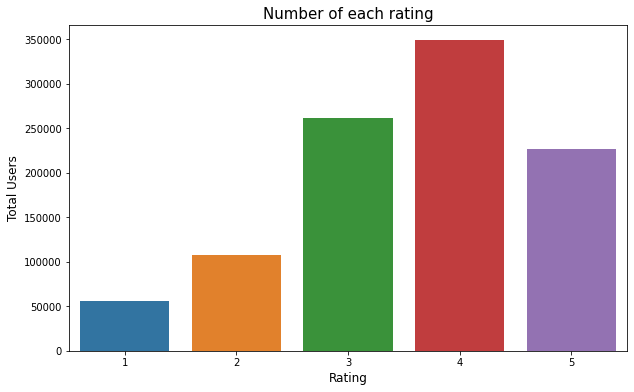

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating',data=ratingsData)
plt.xlabel('Rating',fontsize=12)
plt.ylabel('Total Users', fontsize=12)
plt.title('Number of each rating',fontsize=15)
plt.show()

Training the SVD algorithm

In [42]:
data = Dataset.load_builtin('ml-1m')

#randomly split the dataset into 75% train and 25% test set
train, test = train_test_split(data, test_size=.25)

# Create an object of SVD algo.
algorithm = SVD()
t0 = time()

# Train the algorithm on the training dataset, and predict ratings for the testset
algorithm.fit(train)
t1 = time()

print("Total completion time is ",t1-t0)
predictions = algorithm.test(test)
# Then compute RMSE
print("\n")
accuracy.rmse(predictions)

Total completion time is  44.73969626426697


RMSE: 0.8783


0.8782717154814735

Extracting the top n = 20 recommendations by the trained algorithm

In [20]:
##Helper function to extract top 20 recommendations
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    """

    # First map the predictions to each user.
    topN = defaultdict(list)
    for userid, iid, true_r, est, _ in predictions:
        topN[userid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for userid, user_ratings in topN.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        topN[userid] = user_ratings[:n]

    return topN

In [21]:
#Predictions made by the SVD model
predictions = algorithm.test(test)
top_1_recos = get_top_n(predictions, n=1)
top_5_recos = get_top_n(predictions, n=5)

In [22]:
#Sampling 20 users from the test dataset for analysis
sample_test_set= test[0:20]
sample_test_set_df=pd.DataFrame(sample_test_set, columns=['userId', 'productId','Rating'])
print(sample_test_set_df)

   userId productId  Rating
0     529      1610     5.0
1    1149      2716     4.0
2    4404      1616     2.0
3    3953      1608     4.0
4    3178      2826     3.0
5    5321      1885     3.0
6    3532       457     4.0
7     391      1303     5.0
8    4571         1     5.0
9    5614       413     4.0
10   4774      3158     3.0
11   4311       608     2.0
12     48      2078     4.0
13   5023      1288     5.0
14   1497      2023     2.0
15    216      3168     5.0
16   3778       711     2.0
17   5575       765     4.0
18   3300       316     3.0
19   1758      2470     2.0


In [37]:
#Comparing the predicted and real value of the ratings for the sampled test dataset
for uid,pid,r in sample_test_set:
    pred_start_time=datetime.datetime.now()
    prediction = algorithm.predict(uid=uid, iid=pid,r_ui =None)
    pred_end_time=datetime.datetime.now()
    top_1=[iid for (iid, _) in top_1_recos[uid]]
    top_5=[iid for (iid, _) in top_5_recos[uid]]
    top_1_acc=False
    top_5_acc=False
    if pid in top_1:
        top_1_acc=True
    if pid in top_5:
        top_5_acc=True
    
    print("userId: ",uid, "movieId ", pid)
    print("Predicted rating ", prediction.est, " Real rating", r)
    print("Prediction time ", (pred_end_time - pred_start_time).total_seconds() , "ms")
    print("Best movie recommendation : ", top_1)
    print("Top-5 movie recommendations : ",top_5)
    print("\n")

userId:  529 movieId  1610
Predicted rating  4.41516573013273  Real rating 5.0
Prediction time  0.00025 ms
Best movie recommendation :  ['969']
Top-5 movie recommendations :  ['969', '919', '904', '908', '1193']


userId:  1149 movieId  2716
Predicted rating  3.72151319038641  Real rating 4.0
Prediction time  7.8e-05 ms
Best movie recommendation :  ['2858']
Top-5 movie recommendations :  ['2858', '2686', '260', '745', '1104']


userId:  4404 movieId  1616
Predicted rating  1.9357788453277758  Real rating 2.0
Prediction time  4.5e-05 ms
Best movie recommendation :  ['296']
Top-5 movie recommendations :  ['296', '3160', '778', '47', '1923']


userId:  3953 movieId  1608
Predicted rating  3.5566175451968847  Real rating 4.0
Prediction time  1.8e-05 ms
Best movie recommendation :  ['1199']
Top-5 movie recommendations :  ['1199', '2395', '1080', '3000', '1965']


userId:  3178 movieId  2826
Predicted rating  2.678294817322917  Real rating 3.0
Prediction time  1.7e-05 ms
Best movie recommend

In [34]:
#Calculating the best and worst recommendations made by the model.
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est','details'])

best_predictions = df.sort_values(by='rui')[:10]
worst_predictions = df.sort_values(by='rui')[-10:]

In [35]:
print(best_predictions)

         uid   iid  rui       est                    details
180727   770   473  1.0  2.179982  {'was_impossible': False}
53037   5702  3181  1.0  3.862581  {'was_impossible': False}
122582  1383  3715  1.0  2.141806  {'was_impossible': False}
178510  3432  2746  1.0  3.312231  {'was_impossible': False}
222097  3069    66  1.0  1.333355  {'was_impossible': False}
122566  4609   333  1.0  2.793808  {'was_impossible': False}
122561  3683  2657  1.0  2.574710  {'was_impossible': False}
178502  4186  3564  1.0  1.092677  {'was_impossible': False}
237959  5312  1814  1.0  4.079889  {'was_impossible': False}
246288  3001   849  1.0  3.060623  {'was_impossible': False}


In [36]:
print(worst_predictions)

         uid   iid  rui       est                    details
135192  1511  2208  5.0  4.027008  {'was_impossible': False}
135191  3685  1732  5.0  4.926454  {'was_impossible': False}
135186   505  2788  5.0  4.642483  {'was_impossible': False}
135185  1294   232  5.0  4.313939  {'was_impossible': False}
135180  4139  1885  5.0  4.177612  {'was_impossible': False}
135178  1626   247  5.0  4.069065  {'was_impossible': False}
135175  5734   953  5.0  4.509390  {'was_impossible': False}
135170   624  2686  5.0  3.566998  {'was_impossible': False}
135166  4603  2396  5.0  3.864427  {'was_impossible': False}
125026  5352  1028  5.0  3.761438  {'was_impossible': False}


Repeating the process for SVD with n_factors = 50

In [39]:
algorithm_2 = SVD(n_factors=50)
t0=datetime.datetime.now()
resultant_matrix= algorithm_2.fit(train)
t1=datetime.datetime.now()
print("Training time ",  (t1 - t0).total_seconds())

predictions_2 = algorithm_2.test(test)
print("\n")
accuracy.rmse(predictions_2)

Training time  29.962333


RMSE: 0.8735


0.8734690268483478

In [40]:
top_1_recos = get_top_n(predictions_2, n=1)
top_5_recos = get_top_n(predictions_2, n=5)

In [41]:
for uid,pid,r in sample_test_set:
    pred_start_time=datetime.datetime.now()
    prediction = algorithm_2.predict(uid=uid, iid=pid,r_ui =None)
    pred_end_time=datetime.datetime.now()
    top_1=[iid for (iid, _) in top_1_recos[uid]]
    top_5=[iid for (iid, _) in top_5_recos[uid]]
    top_1_acc=False
    top_5_acc=False
    if pid in top_1:
        top_1_acc=True
    if pid in top_5:
        top_5_acc=True
    
    print("userId: ",uid, "movieId ", pid)
    print("Predicted rating ", prediction.est, " Real rating", r)
    print("Prediction time ", (pred_end_time - pred_start_time).total_seconds() , "ms")
    print("Best movie recommendation : ", top_1)
    print("Top-5 movie recommendations : ",top_5)
    print("\n")

userId:  529 movieId  1610
Predicted rating  4.2699429210565105  Real rating 5.0
Prediction time  9.1e-05 ms
Best movie recommendation :  ['750']
Top-5 movie recommendations :  ['750', '1248', '1193', '924', '1225']


userId:  1149 movieId  2716
Predicted rating  3.8130793888024583  Real rating 4.0
Prediction time  5.2e-05 ms
Best movie recommendation :  ['260']
Top-5 movie recommendations :  ['260', '2858', '1104', '3160', '745']


userId:  4404 movieId  1616
Predicted rating  2.1598058381433223  Real rating 2.0
Prediction time  3.3e-05 ms
Best movie recommendation :  ['296']
Top-5 movie recommendations :  ['296', '2028', '1517', '2396', '1923']


userId:  3953 movieId  1608
Predicted rating  3.177152985666586  Real rating 4.0
Prediction time  3.2e-05 ms
Best movie recommendation :  ['1199']
Top-5 movie recommendations :  ['1199', '1197', '1080', '1206', '2395']


userId:  3178 movieId  2826
Predicted rating  2.1656388102401394  Real rating 3.0
Prediction time  9.5e-05 ms
Best movie r

Model Performance Comparison

In [46]:
def compare(algorithm):
  t0=datetime.datetime.now()
  output = algorithm.test(test)
  t1=datetime.datetime.now()
  print("Time taken to predict  ",  (t1 - t0).total_seconds(), " ms")
  accuracy.rmse(output)

In [47]:
compare(algorithm)

Time taken to predict   3.191227  ms
RMSE: 0.8783


In [48]:
compare(algorithm_2)

Time taken to predict   3.013807  ms
RMSE: 0.7762
